## Demonstration of Functions

#### Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from typing import Union, Any, Dict
import ipywidgets as widgets
from tqdm.notebook import tqdm
from uncertainty_estimation import tiffread_utils, fft_funcs, glen_funcs
import itertools



#### Load Bathymetric File

In [8]:
fn = 'sample_tiff.tif'
bathy_dict = tiffread_utils.load_file(filename=fn, 
                       folder='tests', 
                       verbose=False)

# bathy_dict is a dictionary with the following keys:
# 'depth', 'ndv' (no data value), 'resolution', 'dimensions'
depth = tiffread_utils.remove_edge_Nans(depth=bathy_dict['depth'], ndv=bathy_dict['ndv'])
resolution = bathy_dict['resolution']

(1249.0, 0.0)

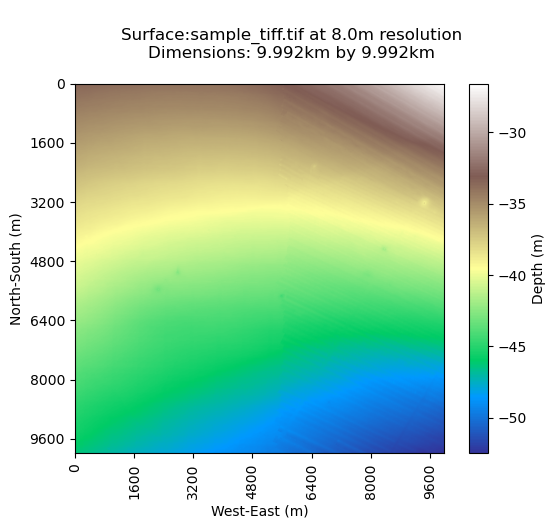

In [10]:
fig, ax1 = plt.subplots(1)
im = ax1.imshow(depth, cmap='terrain', aspect='equal')
fig.colorbar(im, label='Depth (m)')
locs = ax1.get_xticks()
ax1.set_xticks(locs)
ax1.set_xticklabels([str(int(x * resolution)) for x in locs])
locs = ax1.get_yticks()
ax1.set_yticks(locs)
ax1.set_yticklabels([str(int(y * resolution)) for y in locs])
ax1.tick_params(axis='x', labelrotation=90)
ax1.set_xlabel("West-East (m)")
ax1.set_ylabel("North-South (m)")
ax1.set_title(f"""
            Surface:{fn} at {resolution}m resolution
            Dimensions: {depth.shape[0] * resolution/1000}km by {depth.shape[1] * resolution/1000}km
                """)
ax1.set_xlim(left=0, right=depth.shape[1])
ax1.set_ylim(top=0, bottom=depth.shape[0])


#### Compute indices for the segment strips

In [11]:
desired_linespacing_meters = 515 # desired linespacing in meters
multiples = [1, 2, 4]
max_multiple = np.max(multiples) # value used to define the column indices
column_indices = fft_funcs.get_column_indices(array_len=depth.shape[1], 
                                    resolution=resolution, 
                                    linespacing_meters=desired_linespacing_meters, 
                                    max_multiple= max_multiple)
column_ranges = list(zip(column_indices[:-1], column_indices[1:]))

#### Set FFT Method to use

In [14]:
fft_method = 'amplitude'
# options are: 'amplitude', 'psd', 'spectrum'

selection = 'half' # method to select output frequencies

In [31]:
# create placeholder for output
output = np.zeros_like(depth)
output[:] = np.nan
output2 = output.copy()
residuals = output.copy()
interpolation = output.copy()


# for data strip, dimension is the same as linespacing so multiple=1
for col_range in column_ranges:
    segment_data = fft_funcs.get_strip(depth, column_indices=col_range, multiple=1)
    residual_data, interpolated  = fft_funcs.compute_residual(segment_data)
    residuals[:, col_range[0]:col_range[1]+1] = residual_data
    interpolation[:, col_range[0]:col_range[1]+1] = interpolated
    output[:, col_range[0]:col_range[1]+1] = np.apply_along_axis(fft_funcs.compute_fft_uncertainty, axis=1, 
                                                                 arr=residual_data, 
                                                                 resolution=resolution, 
                                                                 multiple=max_multiple,
                                                                 method=fft_method)
    
    

#### Plot Interpolated Surface and Residuals given Linespacing

Text(0.5, 1.0, 'Interpolation Uncertainty')

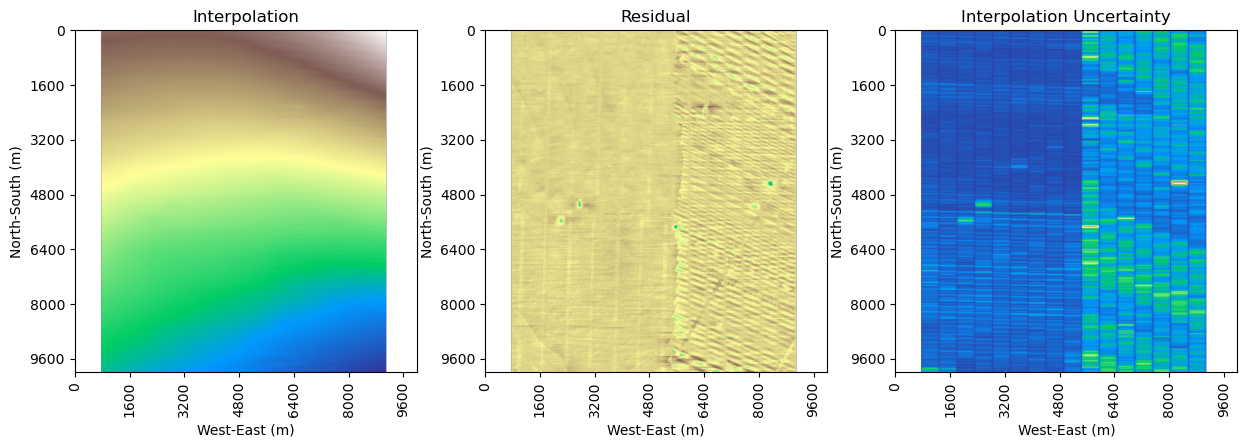

In [46]:

fig, axrow1 = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
ax2 = axrow1[0]
im2 = axrow1[0].imshow(interpolation, cmap='terrain', aspect='equal')
locs = ax2.get_xticks()
ax2.set_xticks(locs)
ax2.set_xticklabels([str(int(x * resolution)) for x in locs])
locs = ax2.get_yticks()
ax2.set_yticks(locs)
ax2.set_yticklabels([str(int(y * resolution)) for y in locs])
ax2.set_xlim(left=0, right=depth.shape[1])
ax2.set_ylim(bottom=depth.shape[0], top=0)
ax2.tick_params(axis='x', labelrotation=90)
ax2.set_xlabel("West-East (m)")
ax2.set_ylabel("North-South (m)")
ax2.set_title(f"Interpolation")

ax3 = axrow1[1]
im3 = axrow1[1].imshow(residuals, cmap='terrain', aspect='equal')
locs = ax3.get_xticks()
ax3.set_xticks(locs)
ax3.set_xticklabels([str(int(x * resolution)) for x in locs])
locs = ax3.get_yticks()
ax3.set_yticks(locs)
ax3.set_yticklabels([str(int(y * resolution)) for y in locs])
ax3.set_xlim(left=0, right=depth.shape[1])
ax3.set_ylim(bottom=depth.shape[0], top=0)
ax3.tick_params(axis='x', labelrotation=90)
ax3.set_xlabel("West-East (m)")
ax3.set_ylabel("North-South (m)")
ax3.set_title(f"Residual")

ax4 = axrow1[2]
im4 = axrow1[2].imshow(output, cmap='terrain', aspect='equal')
locs = ax4.get_xticks()
ax4.set_xticks(locs)
ax4.set_xticklabels([str(int(x * resolution)) for x in locs])
locs = ax4.get_yticks()
ax4.set_yticks(locs)
ax4.set_yticklabels([str(int(y * resolution)) for y in locs])
ax4.set_xlim(left=0, right=depth.shape[1])
ax4.set_ylim(bottom=depth.shape[0], top=0)
ax4.tick_params(axis='x', labelrotation=90)
ax4.set_xlabel("West-East (m)")
ax4.set_ylabel("North-South (m)")
ax4.set_title(f"Interpolation Uncertainty")

#### Print some stats of the Uncertainty Estimate

mean difference: 273599.25


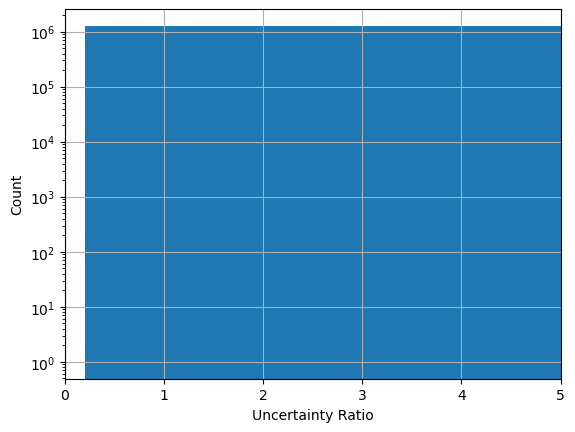

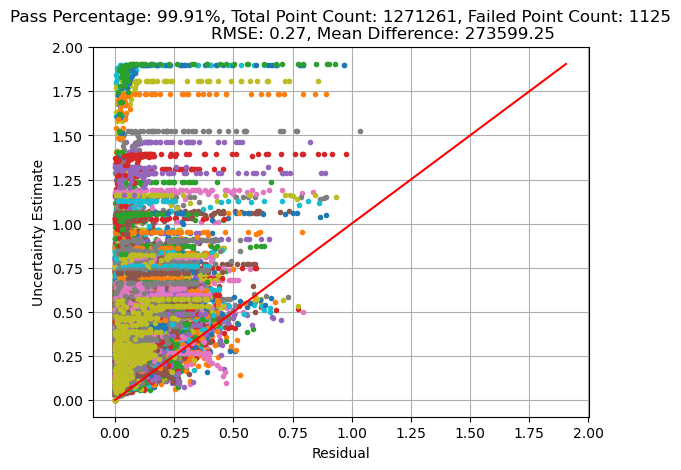

{'fail_pts': 1125,
 'total_pts': 1271261,
 'percentage': 99.91150519051556,
 'mean': np.float32(273599.25),
 'rmse': np.float32(0.26636133)}

In [48]:
stats = glen_funcs.uncertainty_comparison(residuals, output, plot=True)
stats


#### Select row for visualization

In [50]:
select_row = np.random.choice(depth.shape[0])
print(f"Selected Row: {select_row}")

Selected Row: 1019


Text(0.5, 1.0, 'Residual Vs Uncertainty')

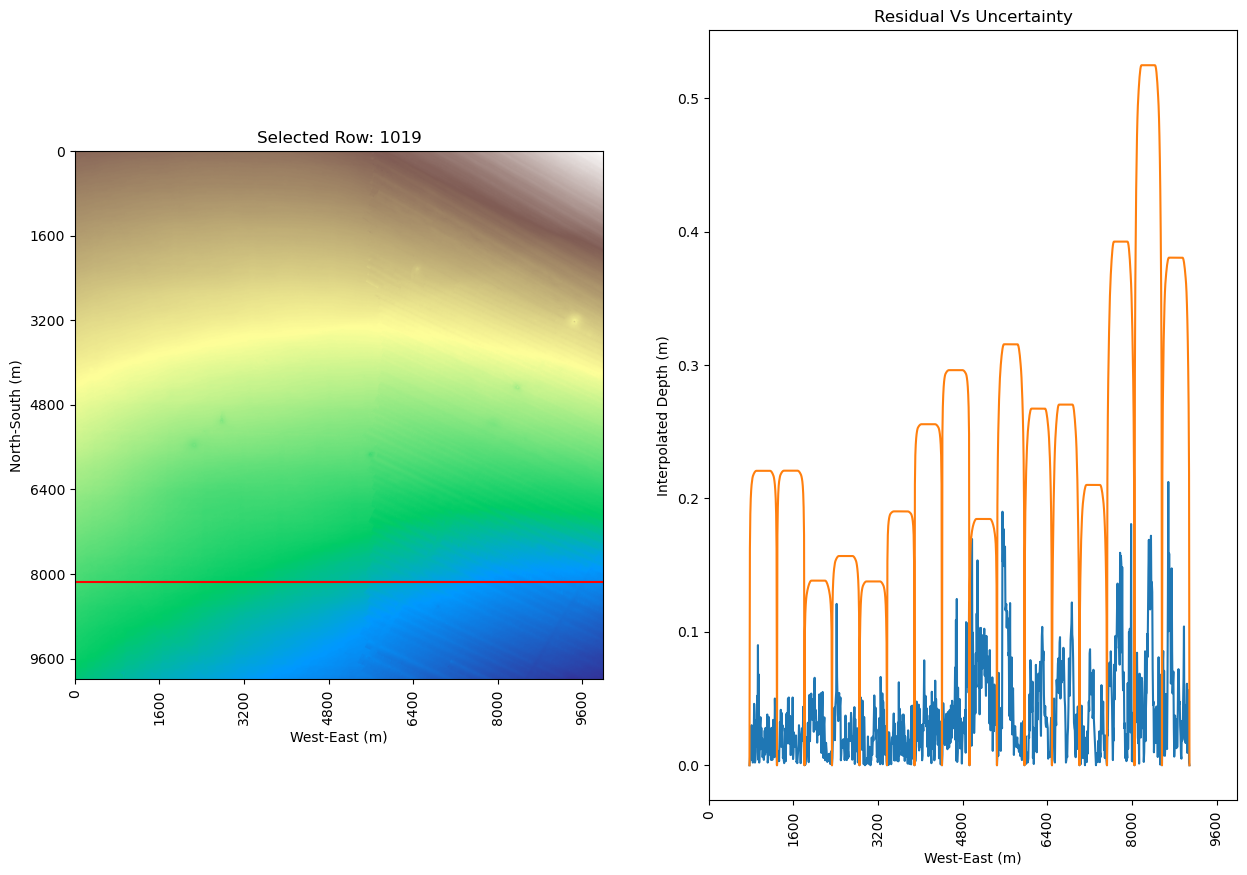

In [55]:


fig, axrow1 = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax2 = axrow1[0]
im2 = axrow1[0].imshow(depth, cmap='terrain', aspect='equal')
locs = ax2.get_xticks()
ax2.set_xticks(locs)
ax2.set_xticklabels([str(int(x * resolution)) for x in locs])
locs = ax2.get_yticks()
ax2.set_yticks(locs)
ax2.set_yticklabels([str(int(y * resolution)) for y in locs])
ax2.set_xlim(left=0, right=depth.shape[1])
ax2.set_ylim(bottom=depth.shape[0], top=0)
ax2.tick_params(axis='x', labelrotation=90)
ax2.hlines(y=select_row, xmin=0, xmax=depth.shape[1], color='red')
ax2.set_xlabel("West-East (m)")
ax2.set_ylabel("North-South (m)")
ax2.set_title(f"Selected Row: {select_row}")

ax3 = axrow1[1]
axrow1[1].plot(np.abs(residuals[select_row]), label='Residuals')
axrow1[1].plot(output[select_row], label='Uncertainty')
locs = ax3.get_xticks()
ax3.set_xticks(locs)
ax3.set_xticklabels([str(int(x * resolution)) for x in locs])
ax3.set_xlim(left=0, right=depth.shape[1])
ax3.tick_params(axis='x', labelrotation=90)
ax3.set_xlabel("West-East (m)")
ax3.set_ylabel("Interpolated Depth (m)")
ax3.set_title(f"Residual Vs Uncertainty")


#### Code Below to be fixed ####

In [ ]:
# def simulate_uncertainty(filenames:list[str], linespacing:list[int], methods:list[str], multiples:list[int], selection:str, window:str):
#     simulation_results = {}
#     for fn in tqdm(filenames):
#         # read bathymetric file and extract metadata
#         bathy_dict = tiffread_utils.load_file(filename=fn, 
#                         folder='../../seafloor_files', 
#                         verbose=False)
#         depth = tiffread_utils.remove_edge_Nans(depth=bathy_dict['depth'], ndv=bathy_dict['ndv'])
#         resolution = bathy_dict['resolution']
        
#         fft_dict = {}
#         for fft_method in methods:
#             linespace_dict = {}
#             for linespace in linespacing:
#                 multiple_dict = {}
#                 for multiple in multiples:
#                     stats_list = []
#                     for i, current_depth in tiffread_utils.generate_augmentations(depth, num=2):
#                         # create placeholders for output
#                         residuals = np.zeros_like(current_depth)
#                         residuals[:] = np.nan
#                         uncertainty = residuals.copy()
                        
#                         column_indices = fft_funcs.get_column_indices(array_len=current_depth.shape[1], 
#                                                 resolution=resolution, 
#                                                 linespacing_meters=linespace, 
#                                                 max_multiple= np.max(multiples))
#                         column_ranges = list(zip(column_indices[:-1], column_indices[1:]))
#                         for col_range in column_ranges:
#                             # for data strip, dimension is the same as linespacing so multiple=1
#                             segment_data = fft_funcs.get_strip(current_depth, column_indices=col_range, multiple=1, verbose=False)
#                             residual_data, _  = fft_funcs.compute_residual(segment_data, verbose=False)
#                             try:
#                                 residuals[:, col_range[0]:col_range[1]+1] = residual_data
#                             except Exception as e:
#                                 print(e)
#                                 print(f"filename: {fn}")
#                                 print(f"fft_method: {fft_method}")
#                                 print(f"linespacing: {linespace}")
#                                 print(f"multiple: {multiple}")
#                                 print(f"col range: {col_range}")
#                                 print(f"current depth shape: {current_depth.shape}")
#                                 print(f"depth width: {current_depth.shape[1]}")
#                                 print(f"col indices: {column_indices}")
#                                 print(f"residual strip width: {residual_data.shape[1]}")
#                                 print(f"segment strip width: {segment_data.shape[1]}")
#                                 print(f"col range: {col_range[0]}:{col_range[1]+1}")
#                                 print(f"max_multiple")
#                             uncertainty[:, col_range[0]:col_range[1]+1] = np.apply_along_axis(fft_funcs.compute_fft_uncertainty, 
#                                                                                         axis=1, arr=residual_data, 
#                                                                                         multiple = multiple,
#                                                                                         resolution=resolution, 
#                                                                                         windowing=window, 
#                                                                                         method = fft_method,
#                                                                                         selection = selection)
#                         uncertainty_stats = glen_funcs.uncertainty_comparison(residuals=residuals, uncertainties=uncertainty)
#                         stats_list.append(uncertainty_stats)
#                     multiple_dict[multiple] = stats_list
#                 linespace_dict[linespace] = multiple_dict
#             fft_dict[fft_method] = linespace_dict
#         simulation_results[fn] = fft_dict
    
#     return simulation_results



# results = simulate_uncertainty(filenames=list1, 
#                                linespacing=linespacing_meters, 
#                                methods=fft_methods, 
#                                multiples=window_multiples, 
#                                selection=selection[0], 
#                                window=window[0])



# def plot_results(results):
#     filenames = results.keys()
#     for fn in filenames:
#         fft_methods = results[fn].keys()
#         for fft_method in fft_methods.keys():
#             linespacing_meters = results[fn][fft_method]
#             for line_meters in linespacing_meters:
#                 multiples = results[fn][fft_method][line_meters]
#                 for multiple in multiples:
#                     stats = results[fn][fft_method][line_meters][multiple]
#                     fail_pts = []
#                     total_pts = []
#                     percentage = []
#                     mean = []
#                     rmse = []
#                     for stat in stats:
#                         fail_pts.append(stat['fail_pts'])
#                         total_pts.append(stat['total_pts'])
#                         percentage.append(stat['percentage'])
#                         mean.append(stat['mean'])
#                         rmse.append(stat['rmse'])
                        